# Assignment 3

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

C:\Users\anton\AppData\Local\Temp\ipykernel_15436\1241375019.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


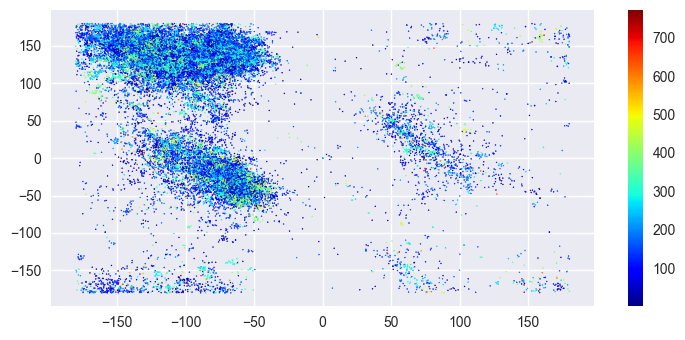

In [12]:
d = pd.read_csv('./data_assignment3.csv')
plt.style.use('seaborn')
xValues = d['phi']
yValues = d['psi']
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.scatter(xValues,yValues,s=0.5, c=d['position'], cmap="jet")

plt.colorbar()

plt.show()

# KMeans

c:\Users\anton\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


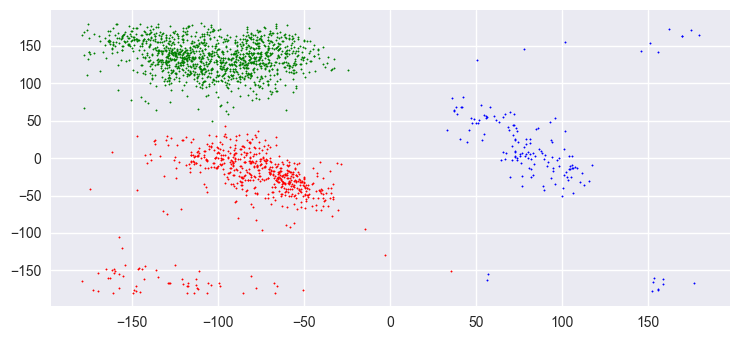

In [13]:
xy_vals = list(zip(xValues, yValues))
X = np.array(xy_vals)

kmeans = KMeans(n_clusters=3).fit_predict(X)
zipped = zip(xy_vals, kmeans)
colors = 'rgbmyck'

for xy, index in list(zipped)[0:2000]:
    plt.scatter(xy[0], xy[1], s=1, c=colors[index])

plt.show()

**3) DBSCAN**

In [18]:
# computing the DBSCAN
db = DBSCAN(eps=2, min_samples=2,).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool) 
core_samples_mask[db.core_sample_indices_] = True 
labels = db.labels_ 

In [15]:
# counting the number of clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1) 

print('Estimated number of clusters: %d' % n_clusters_) 
print('Estimated number of noise points: %d' % n_noise_) 


Estimated number of clusters: 0
Estimated number of noise points: 2


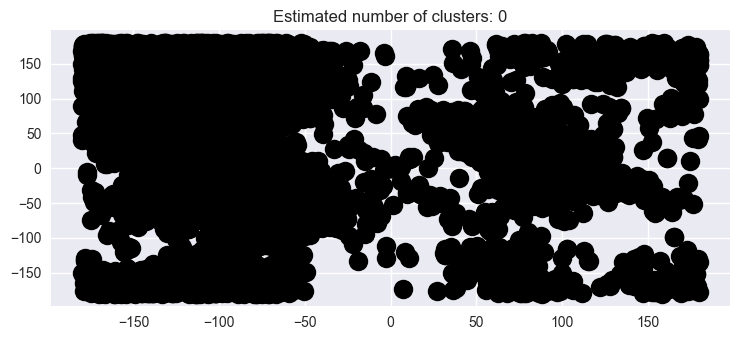

(0       -149.312855
 1        -44.283210
 2       -119.972621
 3       -135.317212
 4       -104.851467
             ...    
 29364   -147.749557
 29365   -117.428541
 29366   -113.586448
 29367   -100.668779
 29368   -169.951240
 Name: phi, Length: 29369, dtype: float64,
 0        142.657714
 1        136.002076
 2       -168.705263
 3        137.143523
 4         95.928520
             ...    
 29364    155.223562
 29365    133.019506
 29366    112.091970
 29367    -12.102821
 29368     94.233680
 Name: psi, Length: 29369, dtype: float64)

In [22]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X
    plt.plot(
        xy[0],
        xy[1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X
    plt.plot(
        xy[0],
        xy[1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()
X

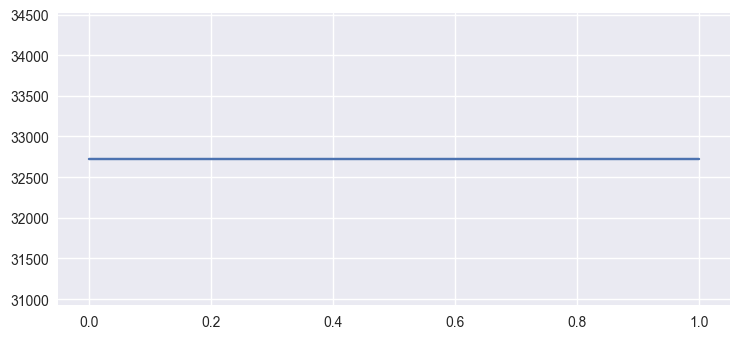

In [20]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)